<a href="https://colab.research.google.com/github/SimoneRosset/AUGMENTATION_GAN/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AUGMENTATION_GAN
based on this [paper](https://arxiv.org/pdf/1803.01229.pdf)

In [ ]:
!pip install torch-summary

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.optim as optim
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate
import gc
import datetime as dt

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/My\ Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('seaborn-white')
import numpy as np
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# functions to show an image

def imshow(img,type_=None,path=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    img_=np.transpose(npimg, (1, 2, 0))
    if img_.shape[2]==1:
      img_=img_[:,:,0]
    
    plt.axis('off')
    if type_=='train':
      plt.title('Train Batch')
    else:
      if type_=='test':
        plt.title('Test Batch')
    plt.imshow(img_, cmap='gray')
    
    if not path == None:
      plt.savefig(path)
    
    plt.show()


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):

    def _name(self):
        return "CNN"

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.conv1 = nn.Sequential(
            self._conv2d(self.channels_size, self.hidden_size),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size , self.hidden_size * 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size * 2),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size*2, self.hidden_size * 4),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size * 4),
            nn.MaxPool2d(2, 2)
        )
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(int(self.hidden_size * 4 * img_dim/8 * img_dim/8), img_dim*4),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(img_dim*4, class_number),
            nn.Softmax(dim=1)
        )
        return self.conv1, self.conv2, self.conv3, self.dense

    def __init__(self, hidden_size, channels_size, class_number):
        super().__init__()
        self.hidden_size = hidden_size
        self.channels_size = channels_size
        self.class_number = class_number
        self._models = self._build_models()
        self.name = self._name()

    def forward(self, image):
        x = self._models[0](image)
        x_1 = self._models[1](x)
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return x_3

In [ ]:
# !git clone https://github.com/vj2050/Transfer-Learning-COVID-19.git

# data_dir_='Transfer-Learning-COVID-19/dataset_4_classes/'

In [ ]:
# img_dim=64
# N_rot=3
# N_flip=5
# N_tran=7
# N_scal=3
# transform_list=[]

# transform_list.append(transforms.Grayscale(num_output_channels=1))

# transform_list.append(transforms.Resize((img_dim*2,img_dim*2),interpolation=2))

# for i in range(N_rot):
#   transform_list.append(transforms.RandomApply([transforms.RandomRotation(degrees=(-2,2))], p=0.5))
# for i in range(N_flip):
#   transform_list.append(transforms.RandomHorizontalFlip(p=0.5))
# # for i in range(N_flip):
# #   transform_list.append(transforms.RandomVerticalFlip(p=0.5))
# for i in range(N_scal):
#   transform_list.append(transforms.RandomApply([transforms.RandomAffine(degrees=0,scale=(0.9,1.1))], p=0.5))
# for i in range(N_tran):
#   transform_list.append(transforms.RandomApply([transforms.RandomAffine(degrees=0,translate=(0.1,0.1))], p=0.5))

# transform_list.append(transforms.Resize((img_dim,img_dim),interpolation=2))

# transform_list.append(transforms.ToTensor())

# transform_list.append(transforms.Normalize((0.5), (0.5)))

# transform_ = transforms.Compose(transform_list)

# transform = transforms.Compose([transforms.ToTensor(),
#                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [125]:
batch_size_train=512
batch_size_test=36
num_samples=batch_size_train*1
img_dim=64

data_dir = 'custom_covid_dataset/classic_augment/4_classes'
data_dir_gan = 'custom_covid_dataset/gan_augment/4_classes'

data_dir_new = 'custom_covid_dataset/classic_augment_2/4_classes'
data_dir_new_new = 'custom_covid_dataset/classic_augment_3/4_classes'

transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

# ORIGINAL TRAIN IMAGES
trainset0 = torchvision.datasets.ImageFolder(os.path.join(
          data_dir, "0/"), transform=transform)

# CLASSIC AUGMENTED TRAIN IMAGES
trainset500 = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_new_new, "500/"), transform=transform)
trainset1000 = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_new_new, "1000/"), transform=transform)
trainset2000 = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_new_new, "2000/"), transform=transform)
trainset3000 = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_new_new, "3000/"), transform=transform)

# GAN AUGMENTED TRAIN IMAGES
trainset100_gan = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_gan, "100/"), transform=transform)
trainset500_gan = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_gan, "500/"), transform=transform)
trainset1000_gan = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_gan, "1000/"), transform=transform)
trainset2000_gan = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_gan, "2000/"), transform=transform)

# CONCATENATION LISTS TRAIN IMAGES
listtrainset_no_aug = [trainset0]
listtrainset_classic = [trainset500,trainset1000,trainset2000,trainset3000]
listtrainset_gan = []

listtrainset = listtrainset_no_aug + listtrainset_classic + listtrainset_gan

trainset_concat = torch.utils.data.ConcatDataset(listtrainset)

sampler = torch.utils.data.RandomSampler(trainset_concat,replacement=True, num_samples=num_samples)
trainloader = torch.utils.data.DataLoader(trainset_concat,  sampler=sampler,
                                          batch_size=batch_size_train, drop_last=True)

# TEST IMAGES
testset0 = torchvision.datasets.ImageFolder(os.path.join( 
          data_dir, "test/"), transform=transform)

testloader = torch.utils.data.DataLoader(testset0, batch_size=batch_size_test, shuffle=False)

classes = ("covid", "normal", "pneumonia_bac", "pneumonia_vir")

In [126]:
print(len(trainloader.dataset))

12270


In [127]:
print(len(testloader.dataset))

36


In [128]:
LOAD_MODEL=False
PATH='custom_covid_dataset/results/CNN_1c_D1CLASSIC+D1GAN_2020-08-18 16:43:38.940131/models/CNN_XRAY-COVID19_300e_0.8028888888888824_acc.pth'
hidden_size=32
channels_size=1
class_number=4
METRIC_FIELDS = [ 'loss', 'tot_acc', 'acc', 'sens', 'spec', 'f1_score']
metrics = {field: list() for field in METRIC_FIELDS}
epochs=750

In [129]:
name_new_folder= 'CNN_'+str(channels_size)+'CH_O'+str(len(listtrainset_no_aug))+'+C'+str(len(listtrainset_classic))+'+G'+str(len(listtrainset_gan))+'_{}'.format(dt.datetime.now())
print('NEW FOLDER: ', name_new_folder)
for func in [lambda: os.mkdir(os.path.join('.','custom_covid_dataset/')),
            lambda: os.mkdir(os.path.join('.', 'custom_covid_dataset/results/')),
            lambda: os.mkdir(os.path.join('.', 'custom_covid_dataset/results/'+ name_new_folder +'/')),
            lambda: os.mkdir(os.path.join('.', 'custom_covid_dataset/results/'+ name_new_folder +'/plots/')),
            lambda: os.mkdir(os.path.join('.', 'custom_covid_dataset/results/'+ name_new_folder +'/models/'))]:
  try:
    func()
  except Exception as error:
    print(error)
    continue

NEW FOLDER:  CNN_1CH_O1+C4+G0_2020-08-20 15:48:39.334047
[Errno 17] File exists: './custom_covid_dataset/'
[Errno 17] File exists: './custom_covid_dataset/results/'


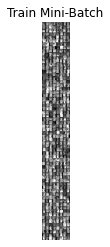

covid normal covid pneumonia_vir normal normal pneumonia_bac pneumonia_vir pneumonia_vir normal covid pneumonia_vir normal pneumonia_bac covid normal covid pneumonia_bac covid covid pneumonia_bac covid covid pneumonia_bac normal covid pneumonia_vir normal pneumonia_vir pneumonia_vir pneumonia_bac covid normal covid normal covid pneumonia_vir pneumonia_bac pneumonia_vir pneumonia_bac pneumonia_vir covid covid covid pneumonia_bac normal pneumonia_vir pneumonia_vir normal covid normal covid covid pneumonia_vir pneumonia_vir normal pneumonia_vir covid pneumonia_bac pneumonia_bac covid pneumonia_vir covid covid normal pneumonia_bac covid covid normal covid pneumonia_bac covid pneumonia_bac normal pneumonia_vir covid covid covid covid pneumonia_bac pneumonia_vir covid normal normal pneumonia_vir covid covid covid covid pneumonia_vir pneumonia_vir pneumonia_bac pneumonia_vir pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_vir normal covid pneumonia_bac normal normal covid normal pneumonia

In [130]:
# get some random training images
dataiter = iter(trainloader)
images_train, labels_train = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images_train),type_='train',path='custom_covid_dataset/results/'+ name_new_folder +'/plots/train_mini_batch.png')
# print labels
print(' '.join('%5s' % classes[labels_train[j]] for j in range(batch_size_train)))

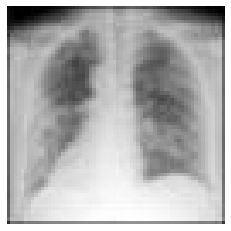

covid


In [131]:
rnd = np.random.randint(0,batch_size_train)
lab_rnd_train=classes[labels_train[rnd]]
imshow(images_train[rnd],path='custom_covid_dataset/results/'+ name_new_folder +'/plots/train_random_%s.png'%(lab_rnd_train))
print(lab_rnd_train)

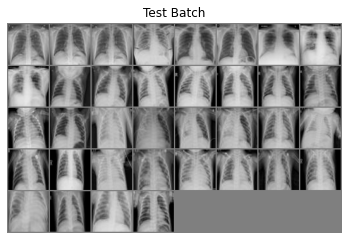

GroundTruth:  covid covid covid covid covid covid covid covid covid normal normal normal normal normal normal normal normal normal pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir


In [132]:
dataiter = iter(testloader)
images_test, labels_test = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images_test),type_='test',path='custom_covid_dataset/results/'+ name_new_folder +'/plots/test_batch.png')
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(batch_size_test)))

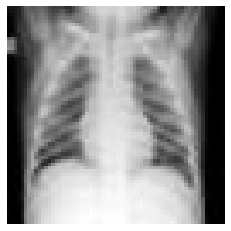

normal


In [133]:
rnd = np.random.randint(0,batch_size_test)
lab_rnd_test = classes[labels_test[rnd]]
imshow(images_test[rnd],path='custom_covid_dataset/results/'+ name_new_folder +'/plots/test_random_%s.png'%(lab_rnd_test))
print(lab_rnd_test)

In [134]:
net=CNN(hidden_size, channels_size, class_number)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# if LOAD_MODEL: 
#   if torch.cuda.is_available():
#     checkpoint = torch.load(PATH)
#   else:
#     checkpoint = torch.load(PATH, map_location=lambda storage, loc: storage)
              
#   net.load_state_dict(checkpoint['state_dict'])
#   optimizer.load_state_dict(checkpoint['optimizer'])
#   metrics=checkpoint['metrics']
#   net.train(mode=False)
#   print('CNN loaded')
#   for i in checkpoint:
#     print(i, ': ', ((str(checkpoint[i])[:75] + '..') if len(str(checkpoint[i])) > 75 else checkpoint[i]))


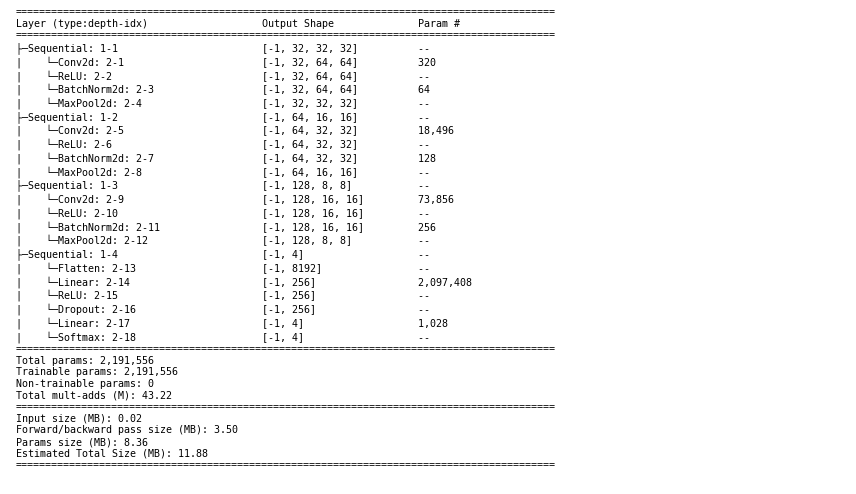

In [135]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

model_stats = summary(net, (channels_size, img_dim, img_dim),verbose=0)
summary_str = str(model_stats)
plt.figure(figsize=(12,7))
plt.text(0.01, 0.05, summary_str, {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('custom_covid_dataset/results/'+ name_new_folder +'/plots/model_summary.png')


Epoch: [497]  => Loss: [0.800]



Epoch: [498]  => Loss: [0.798]



Epoch: [499]  => Loss: [0.797]



Epoch: [500]  => Loss: [0.809]



Epoch: [500]  => Confusion Matrix Test: [50]  => Total Accuracy over 1800 samples: [0.834]


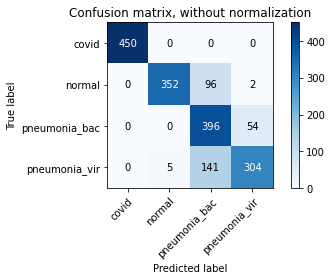

Epoch: [500]  => Evaluation Confusion Matrix Test: [50]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_500_ep_0.834_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.943 │         0.782 │         0.996 │     0.855 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.838 │         0.88  │         0.824 │     0.858 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.888 │         0.676 │         0.959 │     0.764 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [501]  => Loss: [0.787]



Epoch: [502]  => Loss: [0.800]



Epoch: [503]  => Loss: [0.807]



Epoch: [504]  => Loss: [0.819]



Epoch: [505]  => Loss: [0.814]



Epoch: [506]  => Loss: [0.811]



Epoch: [507]  => Loss: [0.799]



Epoch: [508]  => Loss: [0.800]



Epoch: [509]  => Loss: [0.798]



Epoch: [510]  => Loss: [0.790]



Epoch: [510]  => Confusion Matrix Test: [51]  => Total Accuracy over 1800 samples: [0.794]


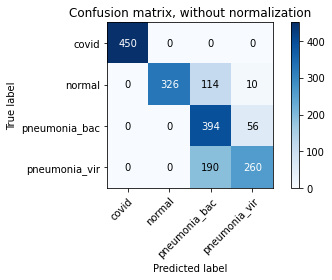

Epoch: [510]  => Evaluation Confusion Matrix Test: [51]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_510_ep_0.794_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.931 │         0.724 │         1     │     0.814 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.8   │         0.876 │         0.775 │     0.836 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.858 │         0.578 │         0.951 │     0.687 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [511]  => Loss: [0.803]



Epoch: [512]  => Loss: [0.802]



Epoch: [513]  => Loss: [0.793]



Epoch: [514]  => Loss: [0.808]



Epoch: [515]  => Loss: [0.797]



Epoch: [516]  => Loss: [0.785]



Epoch: [517]  => Loss: [0.796]



Epoch: [518]  => Loss: [0.800]



Epoch: [519]  => Loss: [0.792]



Epoch: [520]  => Loss: [0.802]



Epoch: [520]  => Confusion Matrix Test: [52]  => Total Accuracy over 1800 samples: [0.838]


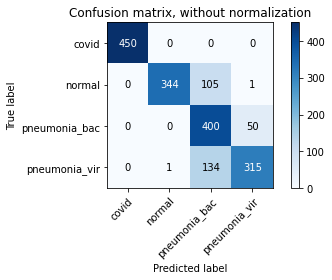

Epoch: [520]  => Evaluation Confusion Matrix Test: [52]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_520_ep_0.838_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.941 │         0.764 │         0.999 │     0.843 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.839 │         0.889 │         0.823 │     0.863 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.897 │         0.7   │         0.962 │     0.784 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [521]  => Loss: [0.810]



Epoch: [522]  => Loss: [0.784]



Epoch: [523]  => Loss: [0.796]



Epoch: [524]  => Loss: [0.792]



Epoch: [525]  => Loss: [0.792]



Epoch: [526]  => Loss: [0.785]



Epoch: [527]  => Loss: [0.791]



Epoch: [528]  => Loss: [0.800]



Epoch: [529]  => Loss: [0.796]



Epoch: [530]  => Loss: [0.794]



Epoch: [530]  => Confusion Matrix Test: [53]  => Total Accuracy over 1800 samples: [0.780]


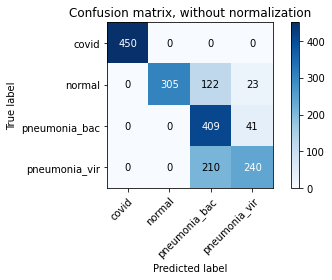

Epoch: [530]  => Evaluation Confusion Matrix Test: [53]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_530_ep_0.780_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.919 │         0.678 │         1     │     0.778 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.793 │         0.909 │         0.754 │     0.846 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.848 │         0.533 │         0.953 │     0.651 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [531]  => Loss: [0.786]



Epoch: [532]  => Loss: [0.796]



Epoch: [533]  => Loss: [0.802]



Epoch: [534]  => Loss: [0.802]



Epoch: [535]  => Loss: [0.802]



Epoch: [536]  => Loss: [0.792]



Epoch: [537]  => Loss: [0.807]



Epoch: [538]  => Loss: [0.797]



Epoch: [539]  => Loss: [0.797]



Epoch: [540]  => Loss: [0.783]



Epoch: [540]  => Confusion Matrix Test: [54]  => Total Accuracy over 1800 samples: [0.801]


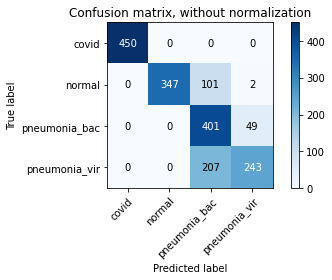

Epoch: [540]  => Evaluation Confusion Matrix Test: [54]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_540_ep_0.801_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.943 │         0.771 │         1     │     0.848 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.802 │         0.891 │         0.772 │     0.844 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.857 │         0.54  │         0.962 │     0.66  │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [541]  => Loss: [0.796]



Epoch: [542]  => Loss: [0.808]



Epoch: [543]  => Loss: [0.805]



Epoch: [544]  => Loss: [0.797]



Epoch: [545]  => Loss: [0.809]



Epoch: [546]  => Loss: [0.794]



Epoch: [547]  => Loss: [0.795]



Epoch: [548]  => Loss: [0.788]



Epoch: [549]  => Loss: [0.797]



Epoch: [550]  => Loss: [0.782]



Epoch: [550]  => Confusion Matrix Test: [55]  => Total Accuracy over 1800 samples: [0.821]


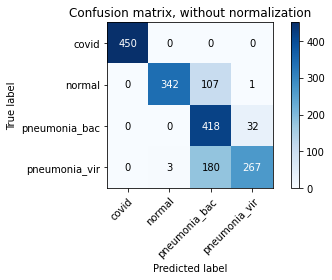

Epoch: [550]  => Evaluation Confusion Matrix Test: [55]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_550_ep_0.821_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.938 │         0.76  │         0.998 │     0.839 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.823 │         0.929 │         0.787 │     0.872 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.88  │         0.593 │         0.976 │     0.705 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [551]  => Loss: [0.804]



Epoch: [552]  => Loss: [0.786]



Epoch: [553]  => Loss: [0.794]



Epoch: [554]  => Loss: [0.799]



Epoch: [555]  => Loss: [0.790]



Epoch: [556]  => Loss: [0.785]



Epoch: [557]  => Loss: [0.779]



Epoch: [558]  => Loss: [0.798]



Epoch: [559]  => Loss: [0.800]



Epoch: [560]  => Loss: [0.807]



Epoch: [560]  => Confusion Matrix Test: [56]  => Total Accuracy over 1800 samples: [0.834]


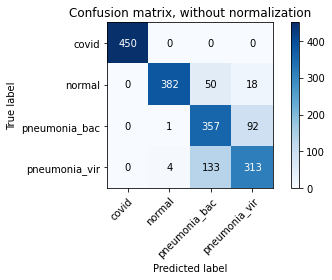

Epoch: [560]  => Evaluation Confusion Matrix Test: [56]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_560_ep_0.834_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.959 │         0.849 │         0.996 │     0.9   │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.847 │         0.793 │         0.864 │     0.818 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.863 │         0.696 │         0.919 │     0.767 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [561]  => Loss: [0.797]



Epoch: [562]  => Loss: [0.793]



Epoch: [563]  => Loss: [0.791]



Epoch: [564]  => Loss: [0.784]



Epoch: [565]  => Loss: [0.792]



Epoch: [566]  => Loss: [0.796]



Epoch: [567]  => Loss: [0.785]



Epoch: [568]  => Loss: [0.791]



Epoch: [569]  => Loss: [0.782]



Epoch: [570]  => Loss: [0.782]



Epoch: [570]  => Confusion Matrix Test: [57]  => Total Accuracy over 1800 samples: [0.801]


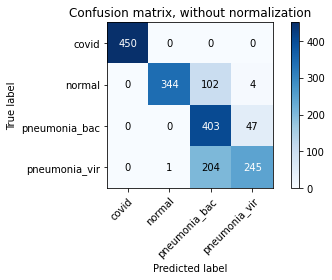

Epoch: [570]  => Evaluation Confusion Matrix Test: [57]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_570_ep_0.801_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.941 │         0.764 │         0.999 │     0.843 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.804 │         0.896 │         0.773 │     0.847 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.858 │         0.544 │         0.962 │     0.664 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [571]  => Loss: [0.794]



Epoch: [572]  => Loss: [0.794]



Epoch: [573]  => Loss: [0.794]



Epoch: [574]  => Loss: [0.792]



Epoch: [575]  => Loss: [0.790]



Epoch: [576]  => Loss: [0.790]



Epoch: [577]  => Loss: [0.792]



Epoch: [578]  => Loss: [0.789]



Epoch: [579]  => Loss: [0.795]



Epoch: [580]  => Loss: [0.782]



Epoch: [580]  => Confusion Matrix Test: [58]  => Total Accuracy over 1800 samples: [0.817]


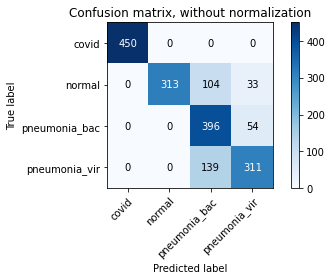

Epoch: [580]  => Evaluation Confusion Matrix Test: [58]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_580_ep_0.817_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.924 │         0.696 │         1     │     0.791 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.835 │         0.88  │         0.82  │     0.856 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.874 │         0.691 │         0.936 │     0.769 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [581]  => Loss: [0.794]



Epoch: [582]  => Loss: [0.801]



Epoch: [583]  => Loss: [0.780]



Epoch: [584]  => Loss: [0.779]



Epoch: [585]  => Loss: [0.782]



Epoch: [586]  => Loss: [0.792]



Epoch: [587]  => Loss: [0.784]



Epoch: [588]  => Loss: [0.776]



Epoch: [589]  => Loss: [0.786]



Epoch: [590]  => Loss: [0.792]



Epoch: [590]  => Confusion Matrix Test: [59]  => Total Accuracy over 1800 samples: [0.796]


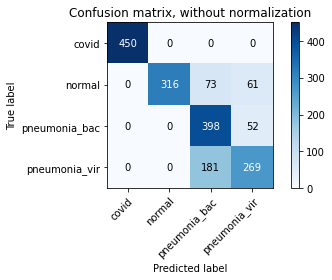

Epoch: [590]  => Evaluation Confusion Matrix Test: [59]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_590_ep_0.796_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.926 │         0.702 │         1     │     0.798 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.83  │         0.884 │         0.812 │     0.856 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.837 │         0.598 │         0.916 │     0.695 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [591]  => Loss: [0.775]



Epoch: [592]  => Loss: [0.781]



Epoch: [593]  => Loss: [0.789]



Epoch: [594]  => Loss: [0.797]



Epoch: [595]  => Loss: [0.781]



Epoch: [596]  => Loss: [0.790]



Epoch: [597]  => Loss: [0.791]



Epoch: [598]  => Loss: [0.783]



Epoch: [599]  => Loss: [0.783]



Epoch: [600]  => Loss: [0.784]



Epoch: [600]  => Confusion Matrix Test: [60]  => Total Accuracy over 18000 samples: [0.786]


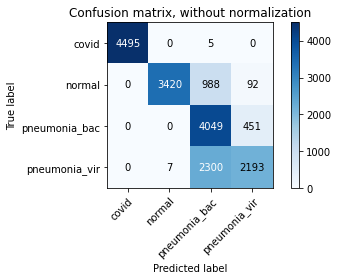

Epoch: [600]  => Evaluation Confusion Matrix Test: [60]


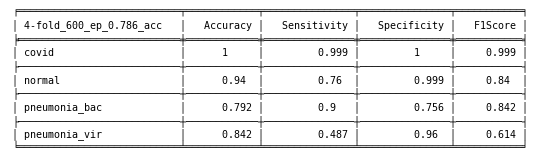

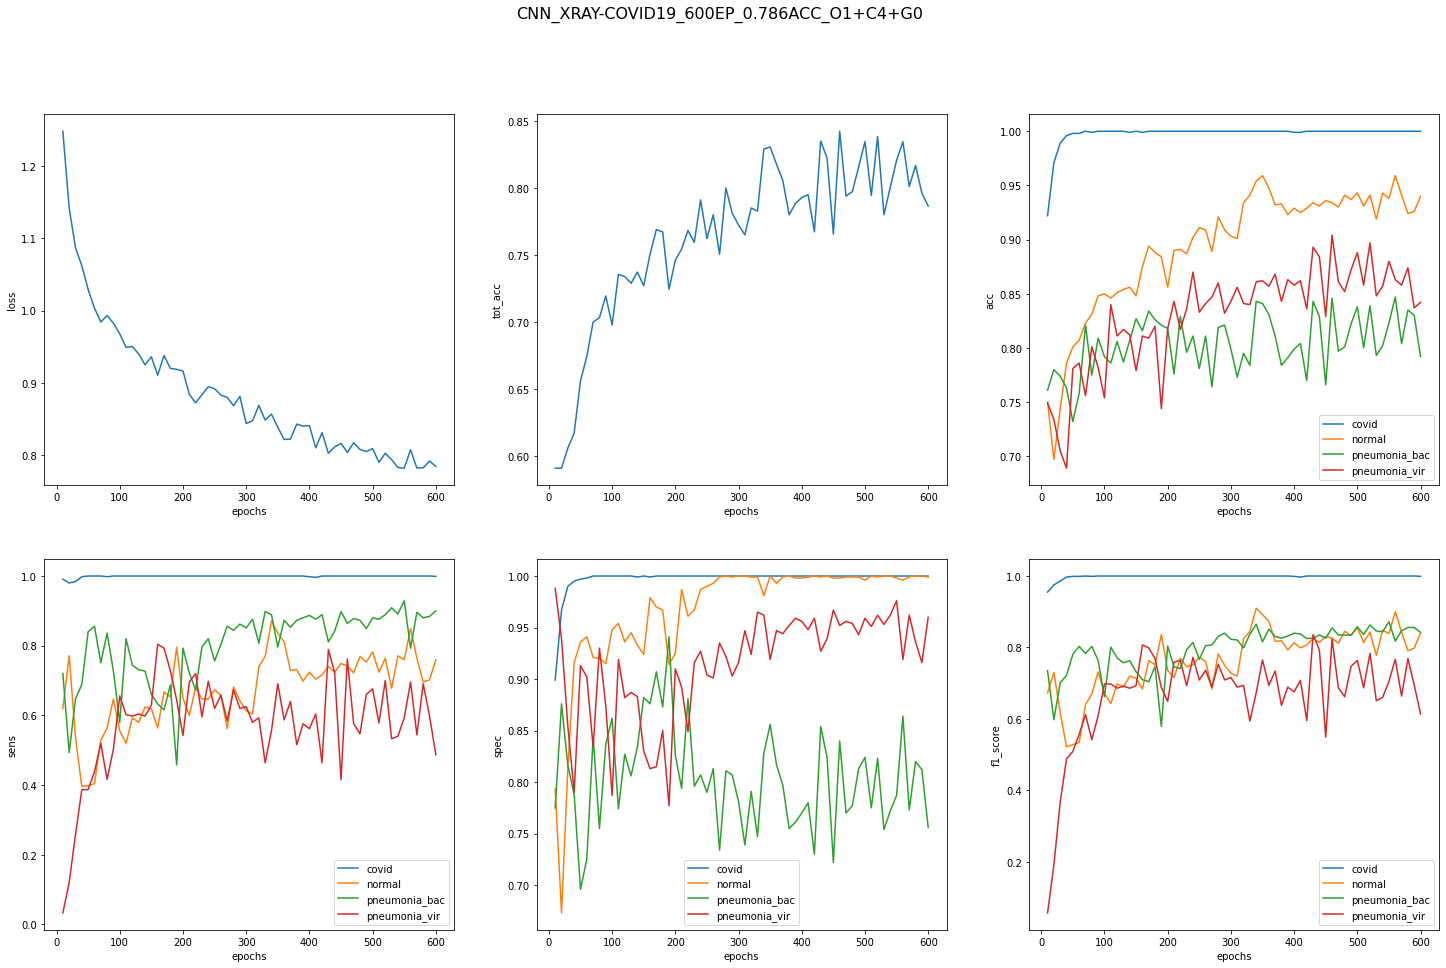


Epoch: [601]  => Loss: [0.794]



Epoch: [602]  => Loss: [0.784]



Epoch: [603]  => Loss: [0.772]



Epoch: [604]  => Loss: [0.783]



Epoch: [605]  => Loss: [0.789]



Epoch: [606]  => Loss: [0.782]



Epoch: [607]  => Loss: [0.788]



Epoch: [608]  => Loss: [0.796]



Epoch: [609]  => Loss: [0.771]



Epoch: [610]  => Loss: [0.784]



Epoch: [610]  => Confusion Matrix Test: [61]  => Total Accuracy over 1800 samples: [0.802]


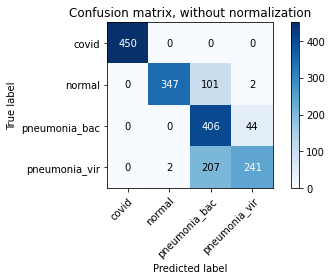

Epoch: [610]  => Evaluation Confusion Matrix Test: [61]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_610_ep_0.802_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.942 │         0.771 │         0.999 │     0.847 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.804 │         0.902 │         0.772 │     0.85  │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.858 │         0.536 │         0.966 │     0.656 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [611]  => Loss: [0.785]



Epoch: [612]  => Loss: [0.775]



Epoch: [613]  => Loss: [0.777]



Epoch: [614]  => Loss: [0.797]



Epoch: [615]  => Loss: [0.795]



Epoch: [616]  => Loss: [0.775]



Epoch: [617]  => Loss: [0.782]



Epoch: [618]  => Loss: [0.786]



Epoch: [619]  => Loss: [0.782]



Epoch: [620]  => Loss: [0.791]



Epoch: [620]  => Confusion Matrix Test: [62]  => Total Accuracy over 1800 samples: [0.804]


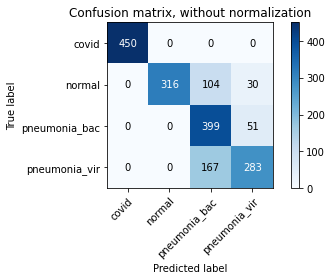

Epoch: [620]  => Evaluation Confusion Matrix Test: [62]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_620_ep_0.804_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.926 │         0.702 │         1     │     0.797 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.821 │         0.887 │         0.799 │     0.852 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.862 │         0.629 │         0.94  │     0.725 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [621]  => Loss: [0.784]



Epoch: [622]  => Loss: [0.776]



Epoch: [623]  => Loss: [0.784]



Epoch: [624]  => Loss: [0.783]



Epoch: [625]  => Loss: [0.800]



Epoch: [626]  => Loss: [0.784]



Epoch: [627]  => Loss: [0.784]



Epoch: [628]  => Loss: [0.790]



Epoch: [629]  => Loss: [0.775]



Epoch: [630]  => Loss: [0.784]



Epoch: [630]  => Confusion Matrix Test: [63]  => Total Accuracy over 1800 samples: [0.817]


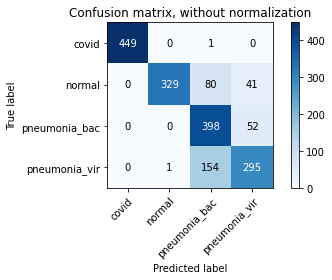

Epoch: [630]  => Evaluation Confusion Matrix Test: [63]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_630_ep_0.817_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      0.999 │         0.998 │         1     │     0.999 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.932 │         0.731 │         0.999 │     0.819 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.841 │         0.884 │         0.826 │     0.861 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.862 │         0.656 │         0.931 │     0.744 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [631]  => Loss: [0.786]



Epoch: [632]  => Loss: [0.780]



Epoch: [633]  => Loss: [0.776]



Epoch: [634]  => Loss: [0.779]



Epoch: [635]  => Loss: [0.787]



Epoch: [636]  => Loss: [0.779]



Epoch: [637]  => Loss: [0.772]



Epoch: [638]  => Loss: [0.780]



Epoch: [639]  => Loss: [0.778]



Epoch: [640]  => Loss: [0.771]



Epoch: [640]  => Confusion Matrix Test: [64]  => Total Accuracy over 1800 samples: [0.804]


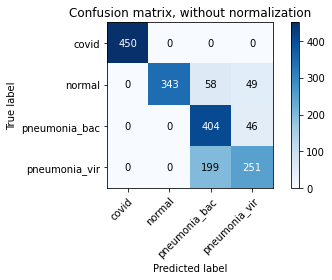

Epoch: [640]  => Evaluation Confusion Matrix Test: [64]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_640_ep_0.804_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │          1    │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.941 │         0.762 │          1    │     0.841 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.832 │         0.898 │          0.81 │     0.862 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.837 │         0.558 │          0.93 │     0.666 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [641]  => Loss: [0.786]



Epoch: [642]  => Loss: [0.781]



Epoch: [643]  => Loss: [0.776]



Epoch: [644]  => Loss: [0.777]



Epoch: [645]  => Loss: [0.775]



Epoch: [646]  => Loss: [0.786]



Epoch: [647]  => Loss: [0.777]



Epoch: [648]  => Loss: [0.775]



Epoch: [649]  => Loss: [0.787]



Epoch: [650]  => Loss: [0.782]



Epoch: [650]  => Confusion Matrix Test: [65]  => Total Accuracy over 1800 samples: [0.827]


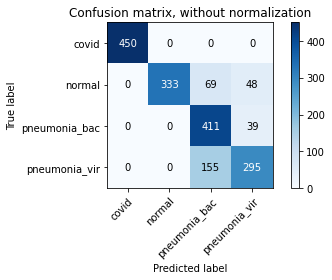

Epoch: [650]  => Evaluation Confusion Matrix Test: [65]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_650_ep_0.827_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.935 │         0.74  │         1     │     0.825 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.854 │         0.913 │         0.834 │     0.882 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.866 │         0.656 │         0.936 │     0.745 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [651]  => Loss: [0.770]



Epoch: [652]  => Loss: [0.772]



Epoch: [653]  => Loss: [0.779]



Epoch: [654]  => Loss: [0.764]



Epoch: [655]  => Loss: [0.768]



Epoch: [656]  => Loss: [0.776]



Epoch: [657]  => Loss: [0.773]



Epoch: [658]  => Loss: [0.763]



Epoch: [659]  => Loss: [0.776]



Epoch: [660]  => Loss: [0.771]



Epoch: [660]  => Confusion Matrix Test: [66]  => Total Accuracy over 1800 samples: [0.819]


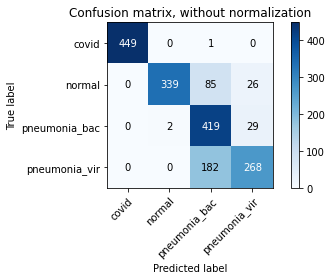

Epoch: [660]  => Evaluation Confusion Matrix Test: [66]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_660_ep_0.819_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      0.999 │         0.998 │         1     │     0.999 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.937 │         0.753 │         0.999 │     0.835 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.834 │         0.931 │         0.801 │     0.879 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.868 │         0.596 │         0.959 │     0.704 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [661]  => Loss: [0.787]



Epoch: [662]  => Loss: [0.770]



Epoch: [663]  => Loss: [0.774]



Epoch: [664]  => Loss: [0.769]



Epoch: [665]  => Loss: [0.776]



Epoch: [666]  => Loss: [0.777]



Epoch: [667]  => Loss: [0.777]



Epoch: [668]  => Loss: [0.774]



Epoch: [669]  => Loss: [0.785]



Epoch: [670]  => Loss: [0.773]



Epoch: [670]  => Confusion Matrix Test: [67]  => Total Accuracy over 1800 samples: [0.804]


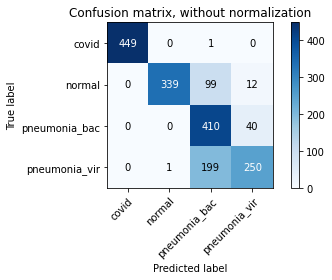

Epoch: [670]  => Evaluation Confusion Matrix Test: [67]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_670_ep_0.804_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      0.999 │         0.998 │         1     │     0.999 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.938 │         0.753 │         0.999 │     0.835 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.812 │         0.911 │         0.779 │     0.858 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.86  │         0.556 │         0.961 │     0.672 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [671]  => Loss: [0.766]



Epoch: [672]  => Loss: [0.777]



Epoch: [673]  => Loss: [0.777]



Epoch: [674]  => Loss: [0.765]



Epoch: [675]  => Loss: [0.783]



Epoch: [676]  => Loss: [0.767]



Epoch: [677]  => Loss: [0.775]



Epoch: [678]  => Loss: [0.787]



Epoch: [679]  => Loss: [0.775]



Epoch: [680]  => Loss: [0.769]



Epoch: [680]  => Confusion Matrix Test: [68]  => Total Accuracy over 1800 samples: [0.787]


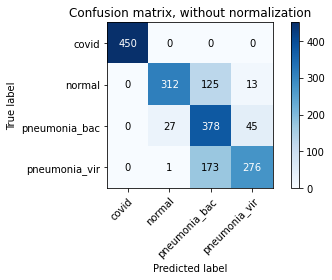

Epoch: [680]  => Evaluation Confusion Matrix Test: [68]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_680_ep_0.787_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.908 │         0.693 │         0.979 │     0.784 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.794 │         0.84  │         0.779 │     0.815 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.871 │         0.613 │         0.957 │     0.717 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [681]  => Loss: [0.775]



Epoch: [682]  => Loss: [0.770]



Epoch: [683]  => Loss: [0.780]



Epoch: [684]  => Loss: [0.768]



Epoch: [685]  => Loss: [0.779]



Epoch: [686]  => Loss: [0.773]



Epoch: [687]  => Loss: [0.783]



Epoch: [688]  => Loss: [0.782]



Epoch: [689]  => Loss: [0.777]



Epoch: [690]  => Loss: [0.779]



Epoch: [690]  => Confusion Matrix Test: [69]  => Total Accuracy over 1800 samples: [0.802]


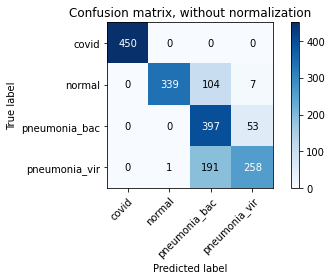

Epoch: [690]  => Evaluation Confusion Matrix Test: [69]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_690_ep_0.802_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.938 │         0.753 │         0.999 │     0.835 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.807 │         0.882 │         0.781 │     0.842 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.86  │         0.573 │         0.956 │     0.686 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [691]  => Loss: [0.771]



Epoch: [692]  => Loss: [0.776]



Epoch: [693]  => Loss: [0.768]



Epoch: [694]  => Loss: [0.776]



Epoch: [695]  => Loss: [0.764]



Epoch: [696]  => Loss: [0.778]



Epoch: [697]  => Loss: [0.775]



Epoch: [698]  => Loss: [0.781]



Epoch: [699]  => Loss: [0.768]



Epoch: [700]  => Loss: [0.778]



Epoch: [700]  => Confusion Matrix Test: [70]  => Total Accuracy over 1800 samples: [0.828]


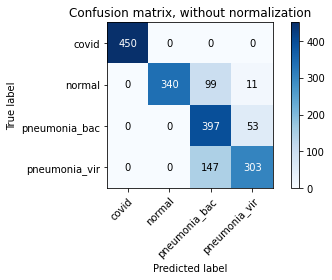

Epoch: [700]  => Evaluation Confusion Matrix Test: [70]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_700_ep_0.828_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.939 │         0.756 │         1     │     0.837 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.834 │         0.882 │         0.818 │     0.857 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.883 │         0.673 │         0.953 │     0.763 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [701]  => Loss: [0.772]



Epoch: [702]  => Loss: [0.783]



Epoch: [703]  => Loss: [0.775]



Epoch: [704]  => Loss: [0.782]



Epoch: [705]  => Loss: [0.770]



Epoch: [706]  => Loss: [0.767]



Epoch: [707]  => Loss: [0.772]



Epoch: [708]  => Loss: [0.773]



Epoch: [709]  => Loss: [0.779]



Epoch: [710]  => Loss: [0.773]



Epoch: [710]  => Confusion Matrix Test: [71]  => Total Accuracy over 1800 samples: [0.807]


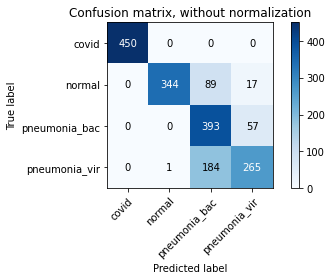

Epoch: [710]  => Evaluation Confusion Matrix Test: [71]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_710_ep_0.807_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.941 │         0.764 │         0.999 │     0.843 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.817 │         0.873 │         0.798 │     0.843 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.856 │         0.589 │         0.945 │     0.696 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [711]  => Loss: [0.773]



Epoch: [712]  => Loss: [0.768]



Epoch: [713]  => Loss: [0.772]



Epoch: [714]  => Loss: [0.773]



Epoch: [715]  => Loss: [0.778]



Epoch: [716]  => Loss: [0.772]



Epoch: [717]  => Loss: [0.771]



Epoch: [718]  => Loss: [0.768]



Epoch: [719]  => Loss: [0.777]



Epoch: [720]  => Loss: [0.777]



Epoch: [720]  => Confusion Matrix Test: [72]  => Total Accuracy over 1800 samples: [0.807]


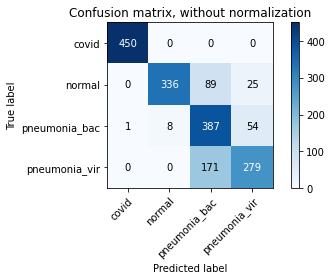

Epoch: [720]  => Evaluation Confusion Matrix Test: [72]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_720_ep_0.807_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      0.999 │         1     │         0.999 │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.932 │         0.747 │         0.994 │     0.828 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.821 │         0.86  │         0.807 │     0.839 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.861 │         0.62  │         0.941 │     0.718 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [721]  => Loss: [0.776]



Epoch: [722]  => Loss: [0.771]



Epoch: [723]  => Loss: [0.766]



Epoch: [724]  => Loss: [0.770]



Epoch: [725]  => Loss: [0.774]



Epoch: [726]  => Loss: [0.770]



Epoch: [727]  => Loss: [0.776]



Epoch: [728]  => Loss: [0.761]



Epoch: [729]  => Loss: [0.768]



Epoch: [730]  => Loss: [0.774]



Epoch: [730]  => Confusion Matrix Test: [73]  => Total Accuracy over 1800 samples: [0.819]


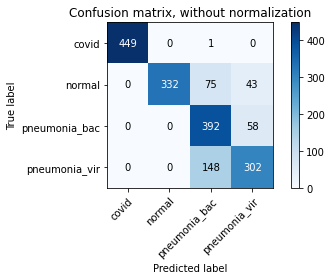

Epoch: [730]  => Evaluation Confusion Matrix Test: [73]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_730_ep_0.819_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      0.999 │         0.998 │         1     │     0.999 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.934 │         0.738 │         1     │     0.824 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.843 │         0.871 │         0.834 │     0.857 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.862 │         0.671 │         0.925 │     0.754 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [731]  => Loss: [0.776]



Epoch: [732]  => Loss: [0.773]



Epoch: [733]  => Loss: [0.775]



Epoch: [734]  => Loss: [0.769]



Epoch: [735]  => Loss: [0.770]



Epoch: [736]  => Loss: [0.769]



Epoch: [737]  => Loss: [0.771]



Epoch: [738]  => Loss: [0.771]



Epoch: [739]  => Loss: [0.769]



Epoch: [740]  => Loss: [0.768]



Epoch: [740]  => Confusion Matrix Test: [74]  => Total Accuracy over 1800 samples: [0.791]


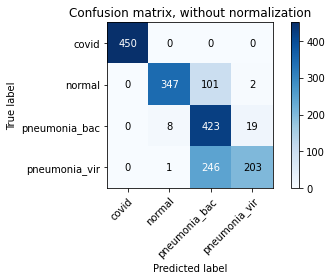

Epoch: [740]  => Evaluation Confusion Matrix Test: [74]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_740_ep_0.791_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.938 │         0.771 │         0.993 │     0.846 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.792 │         0.94  │         0.743 │     0.859 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.851 │         0.451 │         0.984 │     0.586 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [741]  => Loss: [0.765]



Epoch: [742]  => Loss: [0.783]



Epoch: [743]  => Loss: [0.759]



Epoch: [744]  => Loss: [0.762]



Epoch: [745]  => Loss: [0.776]



Epoch: [746]  => Loss: [0.781]



Epoch: [747]  => Loss: [0.767]



Epoch: [748]  => Loss: [0.768]



Epoch: [749]  => Loss: [0.773]



Epoch: [750]  => Loss: [0.770]



Epoch: [750]  => Confusion Matrix Test: [75]  => Total Accuracy over 18000 samples: [0.832]


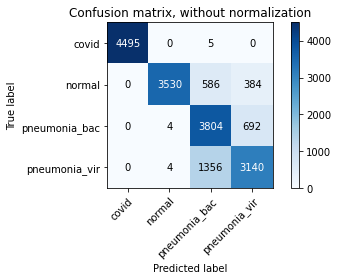

Epoch: [750]  => Evaluation Confusion Matrix Test: [75]


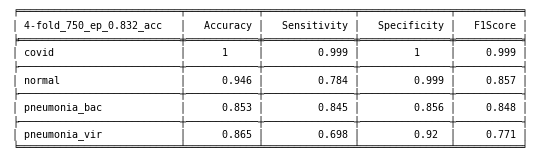

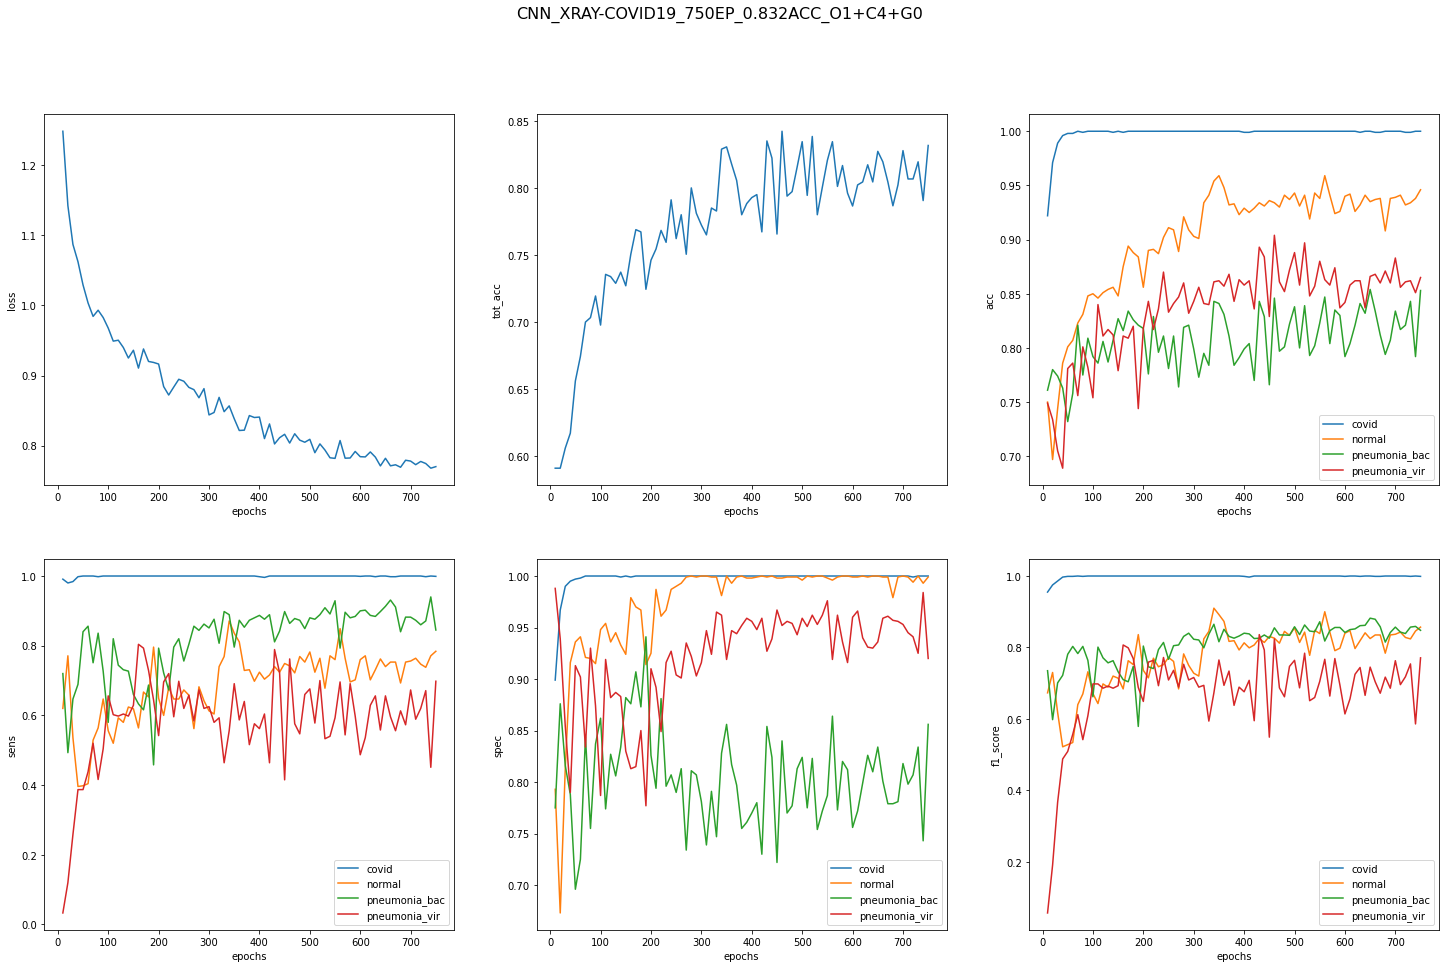

Finished Training


In [136]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for data in notebook.tqdm(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        
        gc.collect()
        if torch.cuda.is_available():
            inputs, labels = data[0].cuda(), data[1].cuda()  
        else:
            inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print("Epoch: [%d]"%(epoch + 1),' => Loss: [%.3f]' %(running_loss / len(trainloader)))
    if (epoch+1)%10==0:
        with torch.no_grad():
            metrics['loss'].append([epoch+1, (running_loss / len(trainloader))])
            accuracy_tot = list(0. for i in range(len(classes)))
            sensitivity_tot = list(0. for i in range(len(classes)))
            specificity_tot = list(0. for i in range(len(classes)))
            f1score_tot = list(0. for i in range(len(classes)))
            table = list(0. for i in range(len(classes)))
            tot_acc_tot=0

            iterations=50
            if (epoch+1)%150==0:
              iterations=500
  
            labels_tot=np.array([],dtype=np.uint8)
            predicted_tot=np.array([],dtype=np.uint8)

            for i in notebook.tqdm(range(iterations)):
              dataiter = iter(testloader)
              images, labels = dataiter.next()

              outputs = net(images.to(device))

              _, predicted = torch.max(outputs, 1)

              labels_tot=np.append(labels_tot,labels.cpu().detach().numpy())
              predicted_tot=np.append(predicted_tot,predicted.cpu().detach().numpy())

              cm = confusion_matrix(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), labels=None, sample_weight=None)

              tot_acc=np.trace(cm)/np.sum(cm)

              tot_acc_tot+=tot_acc

              sensitivity = list(0. for i in range(cm.shape[0]))
              specificity = list(0. for i in range(cm.shape[0]))
              accuracy = list(0. for i in range(cm.shape[0]))
              f1score = list(0. for i in range(cm.shape[0]))

              for i in range(cm.shape[0]):
                TP = cm[i,i]
                FN = np.sum(cm[i,:]) - TP
                FP = np.sum(cm[:,i]) - TP
                TN = (np.sum(cm) - TP - FP - FN)
                accuracy[i] = (TP + TN) / (TP + TN + FP + FN) 
                sensitivity[i] = TP / (TP + FN) 
                specificity[i] = TN / (TN + FP) 
                f1score[i]= 2 * (specificity[i] * sensitivity[i]) / (specificity[i] + sensitivity[i])
              accuracy_tot = [sum(x) for x in zip(accuracy_tot, accuracy)]
              specificity_tot = [sum(x) for x in zip(specificity_tot, specificity)]
              sensitivity_tot = [sum(x) for x in zip(sensitivity_tot, sensitivity)]
              f1score_tot = [sum(x) for x in zip(f1score_tot, f1score)]
              
            accuracy_tot = [round((x/iterations),3) for x in accuracy_tot]
            specificity_tot = [round((x/iterations),3) for x in specificity_tot]
            sensitivity_tot = [round((x/iterations),3) for x in sensitivity_tot]
            f1score_tot = [round((x/iterations),3) for x in f1score_tot]
            tot_acc_tot/=iterations
            running_loss/=(iterations*len(testloader))

            metrics['tot_acc'].append([epoch+1, tot_acc_tot])
            metrics['acc'].append([epoch+1, accuracy_tot])
            metrics['spec'].append([epoch+1, specificity_tot])
            metrics['sens'].append([epoch+1, sensitivity_tot])
            metrics['f1_score'].append([epoch+1, f1score_tot])

            table=[classes, accuracy_tot, sensitivity_tot, specificity_tot, f1score_tot]
            table=np.array(table).T.tolist()

            plot_confusion_matrix(labels_tot, predicted_tot, classes=np.asarray(classes), normalize=False)
            
            print("Epoch: [%d]"%(epoch + 1)," => Confusion Matrix Test: [%d]" %(int((epoch+1)/10))," => Total Accuracy over %d samples: [%.3f]" %(len(testloader.dataset)*iterations, tot_acc_tot))

            if (epoch+1)%150==0:
              plt.gcf().savefig('custom_covid_dataset/results/'+ name_new_folder +'/plots/confusion_matrix_%d_ep_%.3f_acc.png' % ((epoch + 1),tot_acc_tot))
            
            plt.show()

            print("Epoch: [%d]"%(epoch + 1)," => Evaluation Confusion Matrix Test: [%d]" %(int((epoch+1)/10)))

            tab = tabulate(table, headers=['%d-fold_%d_ep_%.3f_acc' % (len(classes),(epoch + 1),tot_acc_tot),'Accuracy','Sensitivity', 'Specificity', 'F1Score'], tablefmt='fancy_grid')

            if (epoch+1)%150==0:
              plt.figure(figsize=(8,2.5))
              plt.text(0.01, 0.05, tab, {'fontsize': 10}, fontproperties = 'monospace') 
              plt.axis('off')
              plt.tight_layout()
              plt.savefig('custom_covid_dataset/results/'+ name_new_folder +'/plots/k_fold_%d_ep_%.3f_acc.png' % ((epoch + 1),tot_acc_tot))
              plt.show()
            else:
              print(tab)

            if (epoch+1)%150==0:
              PATH = 'custom_covid_dataset/results/'+ name_new_folder +'/models/'
              NAME = 'CNN_XRAY-COVID19_'+str(epoch+1)+'EP_'+str(round(tot_acc_tot,3))+'ACC_O'+str(len(listtrainset_no_aug))+'+C'+str(len(listtrainset_classic))+'+G'+str(len(listtrainset_gan))
              EXT = '.pth'
              states = {
                      'state_dict': net.state_dict(),
                      'optimizer': optimizer.state_dict(),
                      'device': device,
                      'classes': classes,
                      'metrics': metrics,
                      'train_epoch': epoch+1,
                      'dataset_code': 'O'+str(len(listtrainset_no_aug))+'+C'+str(len(listtrainset_classic))+'+G'+str(len(listtrainset_gan)),
                      'dataset_length': len(trainloader.dataset),
                      'batch': num_samples,
                      'mini-batch': batch_size_train,
                      'img_dim': (img_dim,img_dim,channels_size),
                      'date': dt.datetime.now().strftime("%Y-%m-%d_%H:%M:%S"),
              }
              torch.save(states, PATH+NAME+EXT)
              fig = plt.figure(figsize=(25,15))
              fig.suptitle(NAME, fontsize=16)
              fig.subplots_adjust(hspace=0.2, wspace=0.2)
              for i in range(1, len(METRIC_FIELDS)+1):
                  ax = fig.add_subplot(2, 3, i)
                  if type(metrics[METRIC_FIELDS[i-1]][1][1])==list:
                    for j in range(len(classes)):
                      ax.plot([x[0] for x in metrics[METRIC_FIELDS[i-1]]],[x[1][j] for x in metrics[METRIC_FIELDS[i-1]]], label=classes[j])
                    ax.legend()
                  else:
                    ax.plot([x[0] for x in metrics[METRIC_FIELDS[i-1]]],[x[1] for x in metrics[METRIC_FIELDS[i-1]]])
                  ax.set(ylabel=METRIC_FIELDS[i-1],xlabel='epochs')
              get_fig = plt.gcf()
              get_fig.savefig('custom_covid_dataset/results/'+ name_new_folder +'/plots/%s.png' % (NAME))
              plt.show()
    running_loss = 0.0
print('Finished Training')


Reference to estimated values

<img src="https://devopedia.org/images/article/208/6541.1566280388.jpg" alt="Drawing" width= '400px'/>
